# Smoke Mortality Analysis

This notebook analyzes the impact of wildfire smoke on mortality rates globally. It compares baseline PM2.5 concentrations with no-fire scenarios to estimate the number of deaths attributable to wildfire smoke.

## Data Requirements

This notebook requires the following data files in the `./data/` directory:
- PM2.5 concentration files:
  - `CESM_09x125_PM25_2050_RCP85.nc`: Baseline PM2.5 concentrations for 2050
  - `CESM_09x125_PM25_2050_RCP85_nofire.nc`: No-fire PM2.5 concentrations for 2050
  - `CESM_09x125_PM25_2000_Baseline.nc`: Baseline PM2.5 concentrations for 2000
  - `CESM_09x125_PM25_2000_Baseline_nofire.nc`: No-fire PM2.5 concentrations for 2000
- `death_rate.nc`: Death rates by location (output from country_process_github.ipynb)
- `ssp2_2050_matching.nc`: Population projections
- Natural Earth shapefiles for country boundaries

The notebook will output CSV files with smoke-related mortality estimates by country.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cartopy.io.shapereader as shpreader
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
import pandas as pd
from shapely.geometry import Point, Polygon
from cartopy.io.shapereader import Reader
from rapidfuzz import process
import matplotlib.colors as mcolors

## Setup Data Directory

Check if the data directory exists and contains required files.

In [2]:
# Define the data directory relative to the notebook location
data_dir = './smoke_data'

# Check if data directory exists
if not os.path.exists(data_dir):
    print(f"Error: Data directory '{data_dir}' not found.")
    print("Please create a 'data' directory in the same location as this notebook and add the required data files.")
    required_files = [
        'CESM_09x125_PM25_2050_RCP85.nc',
        'CESM_09x125_PM25_2050_RCP85_nofire.nc',
        'CESM_09x125_PM25_2000_Baseline.nc',
        'CESM_09x125_PM25_2000_Baseline_nofire.nc',
        'death_rate.nc',
        'ssp2_2050_matching.nc'
    ]
    print(f"Required files: {', '.join(required_files)}")
    # Uncomment the line below if you want the notebook to stop execution when data is missing
    # sys.exit(1)

## Helper Functions

Define utility functions for data processing and visualization.

In [3]:
def fix_lon(ds):
    """Adjust longitude values to ensure they are within (-180, 180) range.
    
    Parameters:
        ds (xarray.Dataset): Dataset with longitude coordinates
        
    Returns:
        xarray.Dataset: Dataset with adjusted longitude coordinates
    """
    lon_name = 'lon'  # whatever name is in the data

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

In [4]:
def global_pcolormesh_country_borders(
    ds,
    title=None,
    cmap='Reds',
    cbar_label=None,
    cbar_ticks=None,
    cbar_ticklabels=None,
    cbar_orientation='vertical',
    vmin=None,
    vmax=None,
    bounds=None,
    colors=None,
    figsize=(10, 5),
):
    """
    Create a global pcolormesh plot with country borders.
    
    Parameters:
        ds (xarray.Dataset): The dataset containing the variable to plot.
        title (str): Title of the plot.
        cmap (str): Colormap to use.
        cbar_label (str): Label for the colorbar.
        cbar_ticks (list): Ticks for the colorbar.
        cbar_ticklabels (list): Tick labels for the colorbar.
        cbar_orientation (str): Orientation of the colorbar ('vertical' or 'horizontal').
        vmin (float): Minimum value for colormap scaling.
        vmax (float): Maximum value for colormap scaling.
        bounds (list): Boundaries for discrete colormap.
        colors (list): Colors for discrete colormap.
        figsize (tuple): Size of the figure.
    
    Returns:
        None
    """
    temp_ds = ds.copy()
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    if bounds is not None:
        norm = mcolors.BoundaryNorm(bounds, len(colors))
        cmap=mcolors.ListedColormap(colors)
        p = temp_ds.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False
        )
    else:
        # Plotting the data
        p = temp_ds.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        
    # Adding country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)

    # Adding title
    if title:
        plt.title(title)
    
    # Adding colorbar
    if cbar_label:
        cbar = plt.colorbar(p, ax=ax, orientation=cbar_orientation)
        cbar.set_label(cbar_label)
        
        if cbar_ticks is not None:
            cbar.set_ticks(cbar_ticks)
        
        if cbar_ticklabels is not None:
            cbar.ax.set_yticklabels(cbar_ticklabels)
    
    plt.show()

In [5]:
# Function to get the sum of values within each country and return as a pandas Series
def sum_within_country(data, countries):
    """Calculate the sum of values within each country's boundaries.
    
    Parameters:
        data (xarray.DataArray): Grid data to sum within country boundaries
        countries (list): List of country geometries
        
    Returns:
        pandas.Series: Series with country names as index and summed values
    """
    temp_data = data.copy()
    country_sums = []
    country_names = []
    
    # Get country info from shapefile
    shapefile = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shapefile)
    country_info = list(reader.records())
    
    # Assuming data is an xarray.DataArray with 'lat' and 'lon' as coordinates
    lats = temp_data.coords['lat'].values
    lons = temp_data.coords['lon'].values
    
    for country, country_attr in zip(countries, country_info):
        clist = []
        country_name = country_attr.attributes['NAME']  # Get country name from the attributes
        country_polygon = shape(country)  # Convert country geometry to a shapely polygon
        
        # Create a meshgrid for latitude and longitude values
        lat_idx, lon_idx = np.meshgrid(lats, lons, indexing="ij")
        
        # Create an array of points
        points = np.array([Point(lon, lat) for lat, lon in zip(lat_idx.ravel(), lon_idx.ravel())])
        
        # Check which points are within the country's polygon
        inside_country = np.array([country_polygon.contains(point) for point in points])
        
        # Get the data values corresponding to the points inside the country
        inside_values = data.values.ravel()[inside_country]
        
        # Sum the values within the country
        country_sum = np.nansum(inside_values)
        
        # Append the country name and its corresponding sum to the lists
        country_sums.append(country_sum)
        country_names.append(country_name)
    
    # Return a pandas Series with the country name as the index and sum as the values
    return pd.Series(country_sums, index=country_names, name='Smoke Deaths')

In [6]:
def mortality(pm25, b=None, population=None):
    """Calculate mortality based on PM2.5 concentration, death rate, and population.
    
    Parameters:
        pm25 (xarray.DataArray): PM2.5 concentration
        b (xarray.DataArray): Death rate (per person)
        population (xarray.DataArray): Population count
        
    Returns:
        xarray.DataArray: Calculated mortality
    """
    temp_ds = b * (1-np.exp(-1.1 * (pm25))) * population
    temp_ds['lon'] = temp_ds['lon']
    return temp_ds

## Load Data

Load PM2.5 concentration data, death rates, and population projections.

In [7]:
# Load PM2.5 data for 2050
try:
    baseline_pm25 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2050_RCP85.nc'))['pm25'].mean(axis=0)
    nofire_pm25 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2050_RCP85_nofire.nc'))['pm25'].mean(axis=0)
    baseline_pm25 = fix_lon(baseline_pm25)
    nofire_pm25 = fix_lon(nofire_pm25)
    print("Successfully loaded PM2.5 data for 2050")
except Exception as e:
    print(f"Error loading PM2.5 data for 2050: {e}")

Successfully loaded PM2.5 data for 2050


/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))
/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))


In [8]:
# Load PM2.5 data for 2000
try:
    baseline_pm25_2000 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2000_Baseline.nc'))['pm25'].mean(axis=0)
    nofire_pm25_2000 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2000_Baseline_nofire.nc'))['pm25'].mean(axis=0)
    baseline_pm25_2000 = fix_lon(baseline_pm25_2000)
    nofire_pm25_2000 = fix_lon(nofire_pm25_2000)
    print("Successfully loaded PM2.5 data for 2000")
except Exception as e:
    print(f"Error loading PM2.5 data for 2000: {e}")

Successfully loaded PM2.5 data for 2000


/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))
/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))


In [9]:
# Load death rate and population data
try:
    death_rate = xr.open_dataset(os.path.join(data_dir, 'death_rate.nc'))['death_rate']/1000  # Convert to per person
    population = xr.open_dataset(os.path.join(data_dir, 'ssp2_2050_matching.nc'))['ssp2_2050']
    death_rate = fix_lon(death_rate)
    population = fix_lon(population)
    
    # Align coordinates
    death_rate['lat'] = baseline_pm25['lat']
    death_rate['lon'] = baseline_pm25['lon']
    population['lat'] = baseline_pm25['lat']
    population['lon'] = baseline_pm25['lon']
    
    print("Successfully loaded death rate and population data")
except Exception as e:
    print(f"Error loading death rate and population data: {e}")

Successfully loaded death rate and population data


/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))
/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_38643/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))


## Calculate Mortality

Calculate mortality based on PM2.5 concentrations, death rates, and population.

In [10]:
# Calculate mortality for 2050
baseline_mortality = mortality(baseline_pm25, b=death_rate, population=population)
nofire_mortality = mortality(nofire_pm25, b=death_rate, population=population)
difference_mortality = baseline_mortality - nofire_mortality

print("Calculated mortality for 2050 scenarios")

Calculated mortality for 2050 scenarios


In [11]:
# Calculate mortality for 2000
baseline_mortality_2000 = mortality(baseline_pm25_2000, b=death_rate, population=population)
nofire_mortality_2000 = mortality(nofire_pm25_2000, b=death_rate, population=population)
difference_mortality_2000 = baseline_mortality_2000 - nofire_mortality_2000

print("Calculated mortality for 2000 scenarios")

Calculated mortality for 2000 scenarios


## Aggregate by Country

Sum mortality values within each country's boundaries.

In [12]:
# Load countries shapefile
try:
    shapefile = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shapefile)
    countries = list(reader.geometries())
    country_info = list(reader.records())
    print(f"Successfully loaded country boundaries from Natural Earth")
except Exception as e:
    print(f"Error loading country boundaries: {e}")

Successfully loaded country boundaries from Natural Earth


In [13]:
# Calculate country-level mortality for 2050
baseline_sums = sum_within_country(baseline_mortality, countries)
nofire_sums = sum_within_country(nofire_mortality, countries)
difference_sums = sum_within_country(difference_mortality, countries)

# Save results to CSV
output_dir = os.path.join(data_dir, 'results')
os.makedirs(output_dir, exist_ok=True)

baseline_sums.to_csv(os.path.join(output_dir, 'total_smoke_deaths.csv'))
nofire_sums.to_csv(os.path.join(output_dir, 'nofire_smoke_deaths.csv'))
difference_sums.to_csv(os.path.join(output_dir, 'fire_smoke_deaths.csv'))

print("Saved 2050 mortality results to CSV files")

Saved 2050 mortality results to CSV files


In [14]:
# Calculate country-level mortality for 2000
baseline_sums_2000 = sum_within_country(baseline_mortality_2000, countries)
nofire_sums_2000 = sum_within_country(nofire_mortality_2000, countries)
difference_sums_2000 = sum_within_country(difference_mortality_2000, countries)

# Save results to CSV
difference_sums_2000.to_csv(os.path.join(output_dir, 'fire_smoke_deaths_2000.csv'))

print("Saved 2000 mortality results to CSV files")

Saved 2000 mortality results to CSV files


## Summary Statistics

Display summary statistics for global mortality.

In [15]:
print(f"Total mortality in 2050 baseline scenario: {baseline_sums.sum():,.0f}")
print(f"Total mortality in 2050 no-fire scenario: {nofire_sums.sum():,.0f}")
print(f"Total mortality attributable to fire in 2050: {difference_sums.sum():,.0f}")

Total mortality in 2050 baseline scenario: 62,499,624
Total mortality in 2050 no-fire scenario: 62,191,602
Total mortality attributable to fire in 2050: 308,022


In [16]:
print(f"Total mortality attributable to fire in 2000: {difference_sums_2000.sum():,.0f}")
print(f"Change in fire-attributable mortality from 2000 to 2050: {(difference_sums.sum() - difference_sums_2000.sum()):,.0f}")

Total mortality attributable to fire in 2000: 247,455
Change in fire-attributable mortality from 2000 to 2050: 60,567


## Visualizations

Create maps to visualize PM2.5 concentrations and mortality.

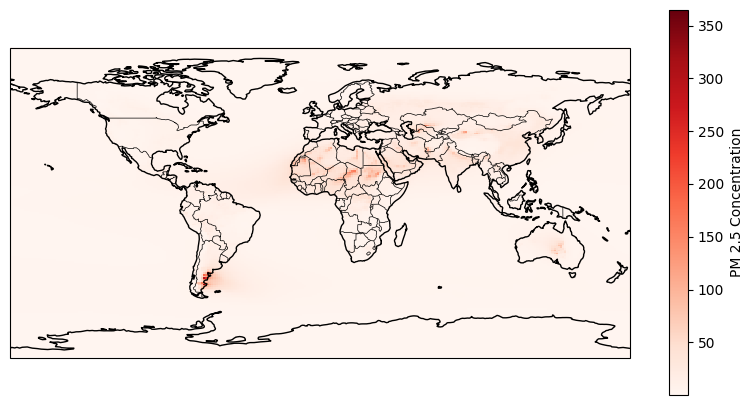

In [ ]:
# Visualize baseline PM2.5 concentrations 2050
global_pcolormesh_country_borders(baseline_pm25, cbar_label='PM 2.5 Concentration',title='Total PM2.5 Concentration 2050')

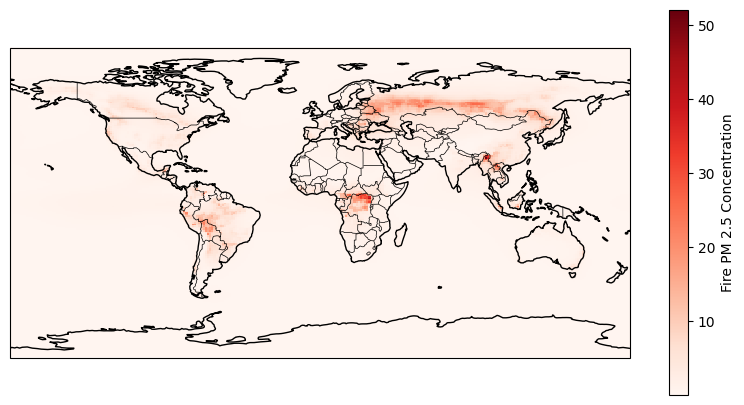

In [ ]:
# Visualize fire contribution to PM2.5 2050
global_pcolormesh_country_borders(baseline_pm25-nofire_pm25, cbar_label='Fire PM 2.5 Concentration',title='Fire PM2.5 Concentration 2050')

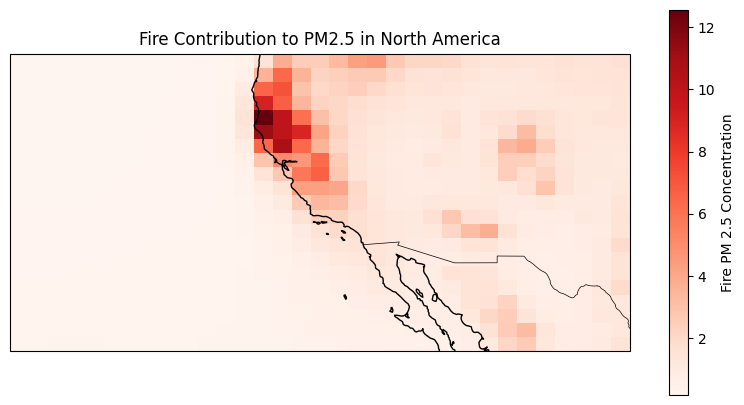

In [ ]:
# Visualize fire contribution to PM2.5 in North America
global_pcolormesh_country_borders(
    baseline_pm25.loc[25:45,-140:-100]-nofire_pm25.loc[25:45,-140:-100],
    cbar_label='Fire PM 2.5 Concentration',
    title='Fire Contribution to PM2.5 in Western North America'
)

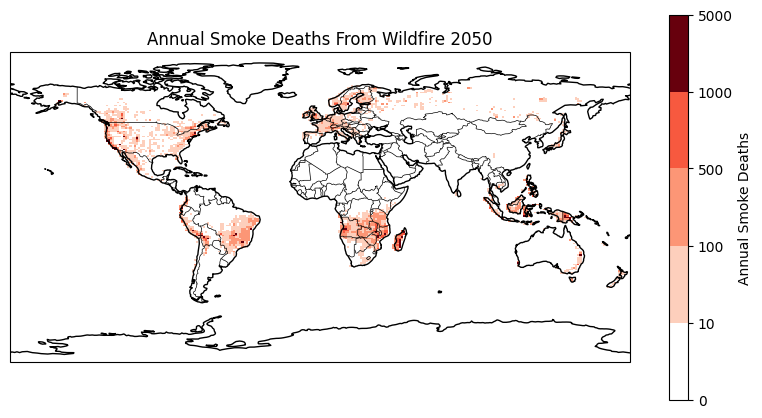

In [20]:
# Visualize smoke deaths in 2050
diff_colors = ('white',"#fdcfbc", "#fc9676", "#f7593f", "#d21e20", "#67000d")
diff_bounds = [0,10,100,500,1000,5000]

global_pcolormesh_country_borders(
    difference_mortality,
    title='Annual Smoke Deaths From Wildfire 2050',
    cbar_label='Annual Smoke Deaths',
    bounds=diff_bounds,
    colors=diff_colors
)

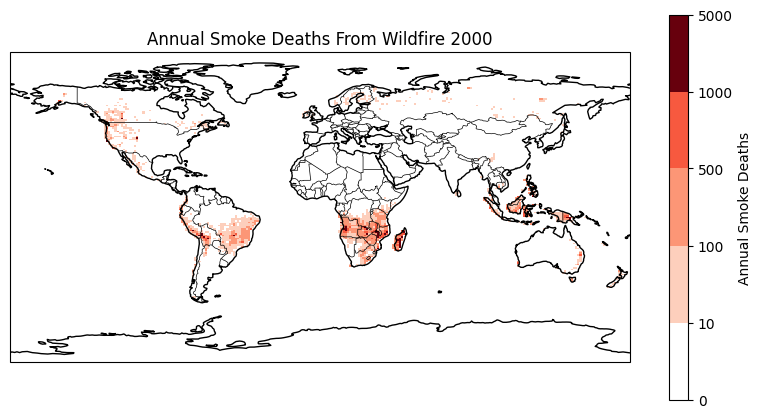

In [21]:
# Visualize smoke deaths in 2000
global_pcolormesh_country_borders(
    difference_mortality_2000,
    title='Annual Smoke Deaths From Wildfire 2000',
    cbar_label='Annual Smoke Deaths',
    bounds=diff_bounds,
    colors=diff_colors
)

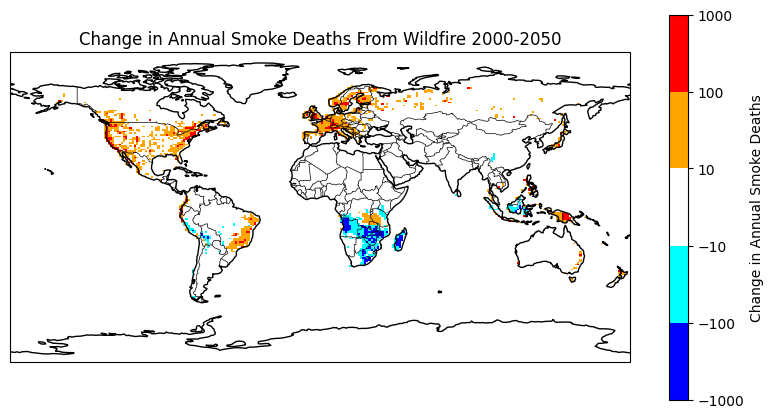

In [30]:
# Visualize change in smoke deaths from 2000 to 2050
change_colors = ('blue', 'cyan', 'white', 'orange', 'red')
change_bounds = [-1000,-100,-10,10,100,1000]

global_pcolormesh_country_borders(
    difference_mortality-difference_mortality_2000,
    title='Change in Annual Smoke Deaths From Wildfire 2000-2050',
    cbar_label='Change in Annual Smoke Deaths',
    bounds=change_bounds,
    colors=change_colors
)

## Country-Level Analysis

Examine the countries most affected by wildfire smoke mortality.

In [23]:
# Top 10 countries with highest smoke deaths in 2050
top_countries_2050 = difference_sums.sort_values(ascending=False).head(10)
print("Top 10 countries with highest smoke deaths in 2050:")
display(top_countries_2050)

Top 10 countries with highest smoke deaths in 2050:


United States of America    58397.145010
Brazil                      32641.157859
Canada                      22959.333347
Mozambique                  20843.577972
Madagascar                  20806.900444
Angola                      15077.803956
Bolivia                     12509.101145
Zambia                      12121.606376
Papua New Guinea            12119.180317
Russia                      11540.821561
Name: Smoke Deaths, dtype: float64

In [24]:
# Top 10 countries with highest increase in smoke deaths from 2000 to 2050
change = difference_sums - difference_sums_2000
top_increase = change.sort_values(ascending=False).head(10)
print("Top 10 countries with highest increase in smoke deaths from 2000 to 2050:")
display(top_increase)

Top 10 countries with highest increase in smoke deaths from 2000 to 2050:


United States of America    48036.051025
Canada                      14357.146874
Brazil                       7652.365434
Russia                       7559.289836
Sweden                       4240.830694
France                       3593.340434
United Kingdom               3329.039158
Papua New Guinea             3083.528212
Norway                       3044.127189
Mexico                       2558.386845
Name: Smoke Deaths, dtype: float64